In [2]:
%%capture
!pip install category_encoders==2.*
!pip install pdpbox
!pip install xgboost

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_plot, pdp_interact_plot
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Import data

In [4]:
file = 'https://raw.githubusercontent.com/boscolio/BW_2/master/Unit_2_BW.csv'

In [5]:
df = pd.read_csv(file, converters={'FIPS':str}).set_index('FIPS')

# EDA

In [6]:
print(df.shape)
df.head()

(3143, 82)


,State,County,PCT_DIABETES_ADULTS08,PCT_DIABETES_ADULTS13,PCT_OBESE_ADULTS08,PCT_OBESE_ADULTS13,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,...,PCH_DIRSALES_07_12,PC_DIRSALES07,PC_DIRSALES12,PCH_PC_DIRSALES_07_12,FMRKT09,FMRKT16,PCH_FMRKT_09_16,FMRKTPTH09,FMRKTPTH16,PCH_FMRKTPTH_09_16
FIPS,,,,,,,,,,,,,,,,,,,,,
01001,AL,Autauga,11.4,13.0,31.5,34.1,18428.439690,17496.693040,-5.056026,33.769657,...,208.000000,1.908215,5.582238,192.537200,2.0,1,-50.0,0.039404,0.018045,-54.204562
01003,AL,Baldwin,9.8,10.4,26.2,27.4,35210.814080,30561.264430,-13.204891,19.318473,...,-9.370629,4.147236,3.403433,-17.934904,4.0,4,0.0,0.022237,0.019179,-13.753638
01005,AL,Barbour,13.6,18.4,37.6,44.4,5722.305602,6069.523628,6.067799,20.840972,...,18.181818,0.396296,0.478663,20.784003,2.0,4,100.0,0.067256,0.154054,129.054496
01007,AL,Bibb,11.1,14.8,32.3,40.3,1044.867327,969.378841,-7.224696,4.559753,...,-56.521739,2.050094,0.883314,-56.913470,1.0,1,0.0,0.046324,0.044164,-4.663693
01009,AL,Blount,11.4,14.1,31.9,34.6,1548.175559,3724.428242,140.568857,2.700840,...,15.384615,7.628023,8.567571,12.317065,1.0,1,0.0,0.017139,0.017330,1.110842


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3143 entries, 01001 to 56045
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   State                     3143 non-null   object 
 1   County                    3143 non-null   object 
 2   PCT_DIABETES_ADULTS08     3138 non-null   float64
 3   PCT_DIABETES_ADULTS13     3142 non-null   float64
 4   PCT_OBESE_ADULTS08        3138 non-null   float64
 5   PCT_OBESE_ADULTS13        3142 non-null   float64
 6   LACCESS_POP10             3143 non-null   float64
 7   LACCESS_POP15             3124 non-null   float64
 8   PCH_LACCESS_POP_10_15     3117 non-null   float64
 9   PCT_LACCESS_POP10         3143 non-null   float64
 10  PCT_LACCESS_POP15         3124 non-null   float64
 11  LACCESS_LOWI10            3143 non-null   float64
 12  LACCESS_LOWI15            3123 non-null   float64
 13  PCH_LACCESS_LOWI_10_15    3115 non-null   float64
 14  PCT_LACC

In [8]:
df.isnull().sum().sort_values(ascending=False).head(30)

PCH_FMRKT_09_16             556
PCH_FMRKTPTH_09_16          551
PCH_PC_DIRSALES_07_12       459
PCH_DIRSALES_07_12          459
PCT_LOCLSALE07              346
PC_DIRSALES07               288
DIRSALES07                  288
PCT_LOCLSALE12              287
PC_DIRSALES12               243
DIRSALES12                  242
PCH_SPECS_09_14             192
PCH_SPECSPTH_09_14          188
PCH_SUPERC_09_14            140
PCH_SUPERCPTH_09_14         139
PCH_DIRSALES_FARMS_07_12    124
PCT_LOCLFARM07               69
PCT_LOCLFARM12               68
DIRSALES_FARMS12             63
DIRSALES_FARMS07             63
PCH_FFR_09_14                51
PCH_FFRPTH_09_14             46
PCH_FSR_09_14                36
PCH_FSRPTH_09_14             31
PCH_LACCESS_LOWI_10_15       28
PCH_LACCESS_POP_10_15        26
PCH_CONVS_09_14              24
LACCESS_LOWI15               20
PCT_LACCESS_SNAP15           20
LACCESS_SNAP15               20
PCH_GROC_09_14               20
dtype: int64

#Wrangle

In [9]:
def wrangle(df):
  df = df.copy()

  # Target is the average obesity
  df['OBESE'] = df[['PCT_OBESE_ADULTS08','PCT_OBESE_ADULTS13']].mean(axis=1)

  # Averaging similar features by date
  df['LILA'] = df[['PCT_LACCESS_LOWI10', 'PCT_LACCESS_LOWI15']].mean(axis=1)
  df['Fast_Food_Rest'] = df[['FFRPTH09','FFRPTH14']].mean(axis=1)
  df['Full_Serv_Rest'] = df[['FSRPTH09', 'FSRPTH14']].mean(axis=1)
  df['PC_FFRSALE'] = df[['PC_FFRSALES07', 'PC_FFRSALES12']].mean(axis=1)
  df['PC_FSRSALE'] = df[['PC_FSRSALES07','PC_FSRSALES12']].mean(axis=1)
  df['Grocery'] = df[['GROCPTH09', 'GROCPTH14']].mean(axis=1)
  df['Supermarket'] = df[['SUPERCPTH09', 'SUPERCPTH14']].mean(axis=1)
  df['Convenience'] = df[['CONVSPTH09', 'CONVSPTH14']].mean(axis=1)
  df['Specialty'] = df[['SPECSPTH09', 'SPECSPTH14']].mean(axis=1)
  df['Farmers_Market'] = df[['FMRKTPTH09', 'FMRKTPTH16']].mean(axis=1)

  # Building new dataframe
  trim = ['OBESE', 'LILA', 'Fast_Food_Rest', 'Full_Serv_Rest',
          'PC_FFRSALE', 'PC_FSRSALE', 'Grocery', 'Supermarket',
          'Convenience', 'Specialty', 'Farmers_Market']
  df = df[trim]

  return df

In [10]:
df_new = wrangle(df)

In [11]:
df_new.head()

,OBESE,LILA,Fast_Food_Rest,Full_Serv_Rest,PC_FFRSALE,PC_FSRSALE,Grocery,Supermarket,Convenience,Specialty,Farmers_Market
FIPS,,,,,,,,,,,
01001,32.80,10.892328,0.602024,0.575786,662.157044,498.331247,0.091521,0.018262,0.538631,0.036525,0.028725
01003,26.80,5.442344,0.641958,1.115162,662.157044,498.331247,0.139347,0.031714,0.626486,0.123490,0.020708
01005,41.00,11.079991,0.788770,0.495888,662.157044,498.331247,0.183375,0.018596,0.606431,0.073350,0.110655
01007,36.30,2.373144,0.263647,0.241852,662.157044,498.331247,0.241852,0.044011,0.747350,0.022216,0.045244
01009,33.25,1.971309,0.391190,0.295615,662.157044,498.331247,0.104295,0.017382,0.504204,0.017440,0.017235


In [90]:
df_new['Specialty'].sort_values()

FIPS
56045    0.000000
32023    0.000000
32021    0.000000
32017    0.000000
32015    0.000000
           ...   
55029    0.610483
08079    0.683060
25007    0.713888
38001    0.849571
46119    1.061175
Name: Specialty, Length: 3143, dtype: float64

In [127]:
print('Chicago specific data:')
df_new.loc[['17031']]

Chicago specific data:


,OBESE,LILA,Fast_Food_Rest,Full_Serv_Rest,PC_FFRSALE,PC_FSRSALE,Grocery,Supermarket,Convenience,Specialty,Farmers_Market
FIPS,,,,,,,,,,,
17031,25.25,1.731041,0.799149,0.704298,619.273324,671.95462,0.277377,0.006797,0.253908,0.084031,0.018325


In [13]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3143 entries, 01001 to 56045
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OBESE           3143 non-null   float64
 1   LILA            3143 non-null   float64
 2   Fast_Food_Rest  3143 non-null   float64
 3   Full_Serv_Rest  3143 non-null   float64
 4   PC_FFRSALE      3143 non-null   float64
 5   PC_FSRSALE      3143 non-null   float64
 6   Grocery         3143 non-null   float64
 7   Supermarket     3143 non-null   float64
 8   Convenience     3143 non-null   float64
 9   Specialty       3143 non-null   float64
 10  Farmers_Market  3143 non-null   float64
dtypes: float64(11)
memory usage: 294.7+ KB


#Split Data

In [14]:
target = 'OBESE'
y = df_new[target]
X = df_new.drop(target, axis=1)

In [15]:
X_main, X_test, y_main, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.25, random_state=42)

#Establish Baseline
This is a regression problem so we will find our MAE.

In [16]:
y_pred = [y_train.mean()] * len(y_train)
baseline = mean_absolute_error(y_train, y_pred)
print('Baseline MAE:', baseline)

Baseline MAE: 2.860211807583252


#Build A Linear Model

In [17]:
model = make_pipeline(
    StandardScaler(),
    LinearRegression(n_jobs=-1)
)

model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression(n_jobs=-1))])

In [18]:
print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))

Training MAE: 2.1829378152870658
Validation MAE: 2.3507300282123866


#Building A Random Forest Regressor Model

In [20]:
model_rfr = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(n_jobs=-1, random_state=42)
)

model_rfr.fit(X_train, y_train);

In [21]:
print('RFR Training MAE:', mean_absolute_error(y_train, model_rfr.predict(X_train)))
print('RFR Validation MAE:', mean_absolute_error(y_val, model_rfr.predict(X_val)))

RFR Training MAE: 0.6264328912466846
RFR Validation MAE: 1.7112313195548499


In [147]:
# We need to correct overfitting on our base model
# Using gridsearch to tune hyperparameters
params = {'randomforestregressor__n_estimators': range(1, 20, 1),
          'randomforestregressor__max_depth': range(1, 7, 1)}

gs = GridSearchCV(model_rfr,
                  param_grid=params,
                  n_jobs=-1,
                  verbose=1,
                  cv=5
)    

In [148]:
gs.fit(X_train, y_train);

Fitting 5 folds for each of 114 candidates, totalling 570 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:    9.2s finished


In [149]:
# Saving our best model
best_model_rfr = gs.best_estimator_
gs.best_params_

{'randomforestregressor__max_depth': 6,
 'randomforestregressor__n_estimators': 19}

In [150]:
print('Tuned RFR Training MAE:', mean_absolute_error(y_train, best_model_rfr.predict(X_train)))
print('Tuned RFR Validation MAE:', mean_absolute_error(y_val, best_model_rfr.predict(X_val)))
print('Tuned RFR Test MAE:', mean_absolute_error(y_test, best_model_rfr.predict(X_test)))

Tuned RFR Training MAE: 1.5117104108725297
Tuned RFR Validation MAE: 1.8194881819123294
Tuned RFR Test MAE: 1.7424408216693308


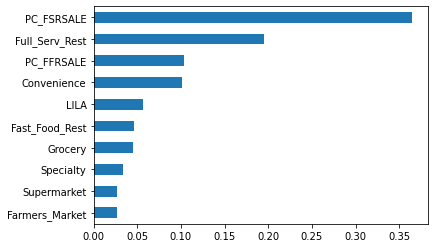

In [82]:
# Feature importances for this model
feat_imp = best_model_rfr.named_steps['randomforestregressor'].feature_importances_

pd.Series(feat_imp, index=X_train.columns).sort_values().plot(kind='barh');

In [41]:
# Building a complete model for Dash App 
model_t_rfr = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(n_jobs=-1, random_state=42, max_depth=18, n_estimators=248)
)

model_t_rfr.fit(X_train, y_train);

# sklearn
# joblib

In [84]:
from joblib import dump
dump(model_t_rfr, 'pipeline.joblib', compress=True)

['pipeline.joblib']

In [86]:
import joblib
import sklearn
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')

joblib==0.16.0
scikit-learn==0.23.2


# Building a XGB Regressor model

In [31]:
model_gb = make_pipeline(
    StandardScaler(),
    XGBRegressor(n_jobs=-1, random_state=42)
)

model_gb.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=-1, num_parallel_tree=1, random_state=42,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [41]:
print('XGBR Training MAE:', mean_absolute_error(y_train, model_gb.predict(X_train)))
print('XGBR Validation MAE:', mean_absolute_error(y_val, model_gb.predict(X_val)))

XGBR Training MAE: 0.25359441873565586
XGBR Validation MAE: 1.8511246473497354


In [67]:
# Tuning hyperparameters
params_gb = {'xgbregressor__n_estimators': range(1, 100, 1),
          'xgbregressor__max_depth': range(1, 20, 1)}

gs_gb = GridSearchCV(model_gb,
                  param_grid=params_gb,
                  n_jobs=-1,
                  verbose=1,
                  cv=5
)   

In [68]:
gs_gb.fit(X_train, y_train);

Fitting 5 folds for each of 1881 candidates, totalling 9405 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1204 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 2410 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 3132 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3942 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4916 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 5942 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 8326 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 9405 out of 9405 | elapsed:  9.1min finished


In [69]:
gs_gb.best_params_

{'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 34}

In [70]:
# Saving our best model
best_model_xgbr = gs_gb.best_estimator_

In [71]:
print('Tuned XGBR Training MAE:', mean_absolute_error(y_train, best_model_xgbr.predict(X_train)))
print('Tuned XGBR Validation MAE:', mean_absolute_error(y_val, best_model_xgbr.predict(X_val)))
print('Tuned XGBR Test MAE:', mean_absolute_error(y_test, best_model_xgbr.predict(X_test)))

Tuned XGBR Training MAE: 1.043782693574536
Tuned XGBR Validation MAE: 1.7251634910110447
Tuned XGBR Test MAE: 1.729195666654311


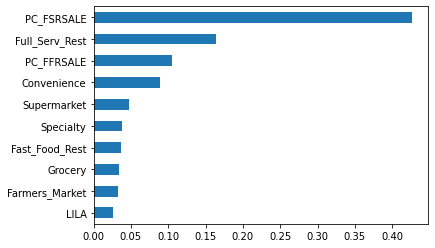

In [72]:
# Plot feature importances for this model
feat_imp = best_model_xgbr.named_steps['xgbregressor'].feature_importances_

pd.Series(feat_imp, index=X_train.columns).sort_values().plot(kind='barh');

# PDP Plots

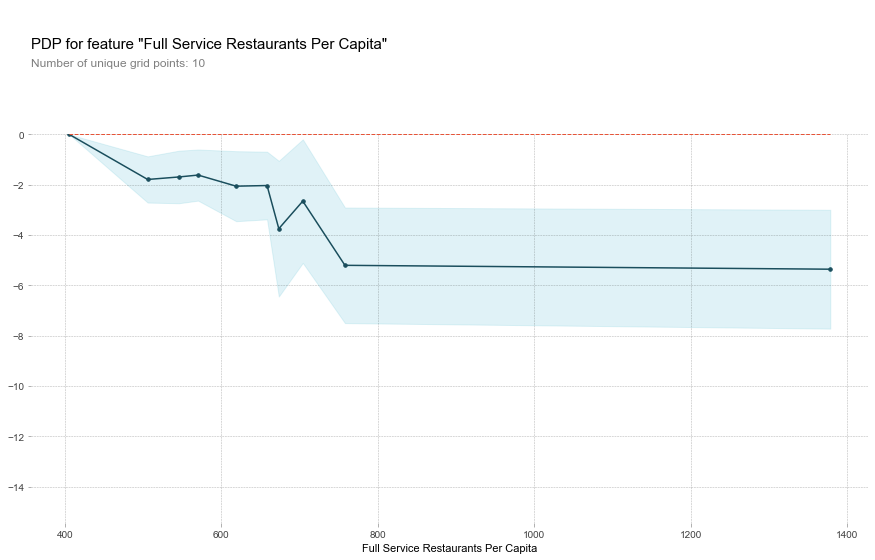

In [42]:
# Looking at a single feature
feature = 'PC_FSRSALE'

isolated = pdp_isolate(
    model=model_t_rfr,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name='Full Service Restaurants Per Capita');

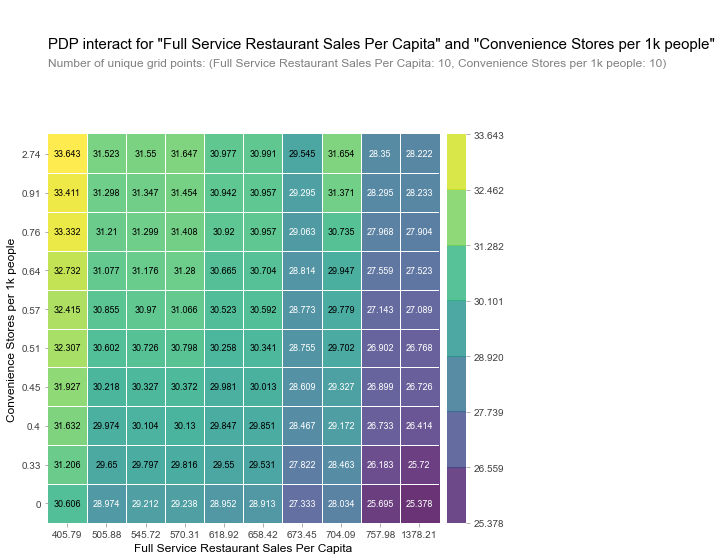

In [43]:
# Looking at the interaction between two features
features = ['PC_FSRSALE', 'Convenience']

interaction = pdp_interact(
    model=model_t_rfr,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

labels = ['Full Service Restaurant Sales Per Capita', 'Convenience Stores per 1k people']
pdp_interact_plot(interaction, plot_type='grid', feature_names=labels);

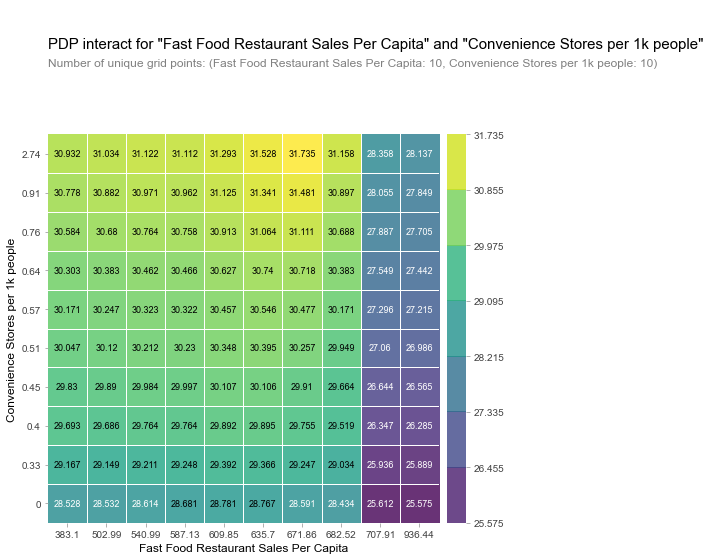

In [49]:
# Interaction between fast food restaurants and convenience stores
features = ['PC_FFRSALE', 'Convenience']

interaction = pdp_interact(
    model=model_t_rfr,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

labels = ['Fast Food Restaurant Sales Per Capita', 'Convenience Stores per 1k people']
pdp_interact_plot(interaction, plot_type='grid', feature_names=labels);